<a href="https://colab.research.google.com/github/guthi1/mooc-exercises/blob/daffy-project/project/solution/dev/yolo_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [1]:
import os
import contextlib
@contextlib.contextmanager
def directory(name):
  ret = os.getcwd()
  os.chdir(name)
  yield None
  os.chdir(ret)

import subprocess
def run(input, exception_on_failure=False):
  try:
    program_output = subprocess.check_output(f"{input}", shell=True, universal_newlines=True, stderr=subprocess.STDOUT)
  except Exception as e:
    if exception_on_failure:
      raise e
    program_output = e.output

    return program_output

def runp(input, exception_on_failure=False):
    print(input)
    print(run(input, exception_on_failure))

#make boxes to xywh format:
def xminyminxmaxymax2xywfnormalized(box, image_size):
    xmin, ymin, xmax, ymax = np.array(box, dtype=np.float64)
    center_x = (xmin+xmax)/2
    center_y = (ymin+ymax)/2
    width = xmax-xmin
    height = ymax-ymin

    normalized = np.array([center_x, center_y, width, height])/image_size
    return np.round(normalized, 5)

def train_test_split(filenames, split_percentage, dataset_dir):
    train_txt = np.array(filenames)
    np.random.shuffle(train_txt)
    nb_things = len(train_txt)
    sp = int(split_percentage * nb_things)
    train_txt, val_txt = train_txt[:sp], train_txt[sp:]

    print("ALL IMAGE NAMES TO MOVE DURING THIS SPLIT:", filenames)
    print("DATASET DIRECTORY", dataset_dir)

    def mv(img_name, to_train):
        print("MOVING IMG NAMED", img_name)

        dest = "train" if to_train else "val"
        runp(f"mv {dataset_dir}/images/{img_name}.jpg {dataset_dir}/{dest}/images/{img_name}.jpg")
        runp(f"mv {dataset_dir}/labels/{img_name}.txt {dataset_dir}/{dest}/labels/{img_name}.txt")

    for img in train_txt:
        mv(img, True)
    for img in val_txt:
        mv(img, False)


@contextlib.contextmanager
def makedirs(name):
    try:
        os.makedirs(name)
    except:
        pass
    yield None

@contextlib.contextmanager
def directory(name):
    ret = os.getcwd()
    os.chdir(name)
    yield None
    os.chdir(ret)

def makedirs(name):
    try:
        os.makedirs(name)
    except:
        pass
    yield None

import cv2

def _mod_mask(mask):
    temp = mask.copy()
    temp[temp == 1] = 50
    temp[temp == 2] = 100
    temp[temp == 3] = 150
    temp[temp == 4] = 200
    temp = temp.astype("uint8")
    mask = cv2.applyColorMap(temp, cv2.COLORMAP_RAINBOW)
    return mask

def display_img_seg_mask(real_img, seg_img):
    all = np.concatenate(
        (cv2.cvtColor(real_img, cv2.COLOR_RGB2BGR), seg_img),
        axis=1
    )

    cv2.imshow("image", all)
    cv2.waitKey(0)

def prun(input, exception_on_failure=False):
  x = run(input, exception_on_failure)
  print(x)
  return x

In [2]:
DATASET_DIR="/dt_dataset"
IMAGE_SIZE = 416
# this is the percentage of data that will go into the training set (as opposed to the testing set)
SPLIT_PERCENTAGE = 0.85

## download dataset

In [ ]:
# Download data:
runp(f"rm -rf {DATASET_DIR}")
runp(f"mkdir {DATASET_DIR}")
runp(f"mkdir {DATASET_DIR}/images")
runp(f"mkdir {DATASET_DIR}/labels")
runp(f"mkdir {DATASET_DIR}/train")
runp(f"mkdir {DATASET_DIR}/val")
runp(f"mkdir {DATASET_DIR}/train/images")
runp(f"mkdir {DATASET_DIR}/train/labels")
runp(f"mkdir {DATASET_DIR}/val/images")
runp(f"mkdir {DATASET_DIR}/val/labels")
!wget -O duckietown_object_detection_dataset.zip https://www.dropbox.com/s/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip?dl=0
runp(f"unzip -q duckietown_object_detection_dataset.zip -d {DATASET_DIR}")
runp(f"mv {DATASET_DIR}/duckietown\ object\ detection\ dataset/* {DATASET_DIR} && rm -rf {DATASET_DIR}/duckietown\ object\ detection\ dataset")
runp(f"rm duckietown_object_detection_dataset.zip")

rm -rf /dt_dataset
None
mkdir /dt_dataset
None
mkdir /dt_dataset/images
None
mkdir /dt_dataset/labels
None
mkdir /dt_dataset/train
None
mkdir /dt_dataset/val
None
mkdir /dt_dataset/train/images
None
mkdir /dt_dataset/train/labels
None
mkdir /dt_dataset/val/images
None
mkdir /dt_dataset/val/labels
None
--2022-12-08 05:35:29--  https://www.dropbox.com/s/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip [following]
--2022-12-08 05:35:29--  https://www.dropbox.com/s/raw/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response..

Resize the images

In [ ]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm

with open(f"{DATASET_DIR}/annotation/final_anns.json") as anns:
    annotations = json.load(anns)

In [ ]:
npz_index = 0

all_image_names = []
    
def save_img(img, boxes, classes):
    global npz_index
    cv2.imwrite(f"{DATASET_DIR}/images/real_{npz_index}.jpg", img)
    with open(f"{DATASET_DIR}/labels/real_{npz_index}.txt", "w") as f:
        for i in range(len(boxes)):
            f.write(f"{classes[i]} "+" ".join(map(str,boxes[i]))+"\n")
    npz_index += 1
    all_image_names.append(f"real_{npz_index}")

filenames = tqdm(os.listdir(f"{DATASET_DIR}/frames"))
for filename in filenames:
    img = cv2.imread(f"{DATASET_DIR}/frames/{filename}")

    orig_y, orig_x = img.shape[0], img.shape[1]
    scale_y, scale_x = IMAGE_SIZE/orig_y, IMAGE_SIZE/orig_x

    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    boxes = []
    classes = []

    if filename not in annotations:
        continue

    for detection in annotations[filename]:
        box = detection["bbox"]
        label = detection["cat_name"]

        if label not in ["duckie", "cone"]:
            continue

        orig_x_min, orig_y_min, orig_w, orig_h = box

        x_min = int(np.round(orig_x_min * scale_x))
        y_min = int(np.round(orig_y_min * scale_y))
        x_max = x_min + int(np.round(orig_w * scale_x))
        y_max = y_min + int(np.round(orig_h * scale_y))

        boxes.append([x_min, y_min, x_max, y_max])
        classes.append(1 if label == "duckie" else 2)

    if len(boxes) == 0:
        continue

    boxes = np.array([xminyminxmaxymax2xywfnormalized(box, IMAGE_SIZE) for box in boxes])
    classes = np.array(classes)-1
    
    save_img(img, boxes, classes)

train_test_split(all_image_names, SPLIT_PERCENTAGE, DATASET_DIR)

100%|██████████| 1963/1963 [00:24<00:00, 79.41it/s]


Streaming output truncated to the last 5000 lines.
None
mv /dt_dataset/labels/real_45.txt /dt_dataset/train/labels/real_45.txt
None
MOVING IMG NAMED real_331
mv /dt_dataset/images/real_331.jpg /dt_dataset/train/images/real_331.jpg
None
mv /dt_dataset/labels/real_331.txt /dt_dataset/train/labels/real_331.txt
None
MOVING IMG NAMED real_107
mv /dt_dataset/images/real_107.jpg /dt_dataset/train/images/real_107.jpg
None
mv /dt_dataset/labels/real_107.txt /dt_dataset/train/labels/real_107.txt
None
MOVING IMG NAMED real_935
mv /dt_dataset/images/real_935.jpg /dt_dataset/train/images/real_935.jpg
None
mv /dt_dataset/labels/real_935.txt /dt_dataset/train/labels/real_935.txt
None
MOVING IMG NAMED real_466
mv /dt_dataset/images/real_466.jpg /dt_dataset/train/images/real_466.jpg
None
mv /dt_dataset/labels/real_466.txt /dt_dataset/train/labels/real_466.txt
None
MOVING IMG NAMED real_155
mv /dt_dataset/images/real_155.jpg /dt_dataset/train/images/real_155.jpg
None
mv /dt_dataset/labels/real_155.txt /

Mounts your google drive to move the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
runp(f"mv {DATASET_DIR} /content/drive/MyDrive/dt_dataset")

mv /dt_dataset /content/drive/MyDrive/dt_dataset
mv: inter-device move failed: '/dt_dataset' to '/content/drive/MyDrive/dt_dataset/dt_dataset'; unable to remove target: Directory not empty



## Extract dataset from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
runp(f"cp -r /content/drive/MyDrive/dt_dataset /content{DATASET_DIR} ")

cp -r /content/drive/MyDrive/dt_dataset /content/dt_dataset 
None


In [ ]:
os.chdir(f'/content{DATASET_DIR}')

In [ ]:
if not os.path.exists("SENTINEL"):
  prun("mkdir duckietown_dataset")
  prun("mv train duckietown_dataset && mv val duckietown_dataset")

None
None


## Dataset v2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
runp(f"cp -r /content/drive/MyDrive/data /content{DATASET_DIR} ")

cp -r /content/drive/MyDrive/data /content/dt_dataset 
None


In [5]:
import shutil
import os

In [38]:
# path to source directory
src_dirs = [
    '/content/drive/MyDrive/data/dt_real_voc_test/JPEGImages',
    '/content/drive/MyDrive/data/dt_real_voc_train/JPEGImages',
    '/content/drive/MyDrive/data/dt_real_voc_val/JPEGImages',
    '/content/drive/MyDrive/data/dt_sim_voc_train/JPEGImages',
    '/content/drive/MyDrive/data/dt_sim_voc_val/JPEGImages'
]

# path to destination directory
dest_dir = f'/content{DATASET_DIR}/frames/images'

# getting all the files in the source directory
for src_dir in src_dirs:
    files = os.listdir(src_dir)
    shutil.copytree(src_dir, dest_dir, dirs_exist_ok=True)


In [39]:
# path to source directory
src_dirs = [
    '/content/drive/MyDrive/data/dt_real_voc_test/labels',
    '/content/drive/MyDrive/data/dt_real_voc_train/labels',
    '/content/drive/MyDrive/data/dt_real_voc_val/labels',
    '/content/drive/MyDrive/data/dt_sim_voc_train/labels',
    '/content/drive/MyDrive/data/dt_sim_voc_val/labels'
]

# path to destination directory
dest_dir = f'/content{DATASET_DIR}/frames/labels'

# getting all the files in the source directory
for src_dir in src_dirs:
    files = os.listdir(src_dir)
    shutil.copytree(src_dir, dest_dir, dirs_exist_ok=True)


In [35]:
run(f"mkdir /content{DATASET_DIR}/train")
run(f"mkdir /content{DATASET_DIR}/train/images")
run(f"mkdir /content{DATASET_DIR}/train/labels")
run(f"mkdir /content{DATASET_DIR}/val")
run(f"mkdir /content{DATASET_DIR}/val/images")
run(f"mkdir /content{DATASET_DIR}/val/labels")

In [36]:
run(f"mkdir /content{DATASET_DIR}/images")
run(f"mkdir /content{DATASET_DIR}/labels")

In [ ]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm

npz_index = 0
all_image_names = []
filenames = tqdm(os.listdir(f"/content{DATASET_DIR}/frames/images"))


def save_img(img, boxes, classes):
    global npz_index
    cv2.imwrite(f"/content{DATASET_DIR}/images/real_{npz_index}.jpg", img)
    with open(f"/content{DATASET_DIR}/labels/real_{npz_index}.txt", "w+") as f:
        for i in range(len(boxes)):
            f.write(f"{classes[i]} "+" ".join(map(str,boxes[i]))+"\n")
    npz_index += 1
    all_image_names.append(f"real_{npz_index}")



for filename in filenames:

    # Get data
    img = cv2.imread(f"/content{DATASET_DIR}/frames/images/{filename}")
    labels_path = f"/content{DATASET_DIR}/frames/labels/{filename.strip('.jpg')}.txt"

    # Skip image without any content
    if not os.path.exists(labels_path):
        continue
    if os.path.getsize(labels_path) == 0:
        continue

    # Resize image
    orig_x, orig_y = img.shape[0], img.shape[1]
    scale_x, scale_y = IMAGE_SIZE/orig_x, IMAGE_SIZE/orig_y
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    boxes = []
    classes = []

    with open(labels_path) as f:
        objs = [line.rstrip().split(' ') for line in f]

    for obj in objs:
        label, x, y, w, h = obj

        pt1 = np.array([int(scale_x * orig_x * (float(x) + float(w)/2)), int(scale_y * orig_y * (float(y) + float(h)/2))])
        pt2 = np.array([int(scale_x * orig_x * (float(x) - float(w)/2)), int(scale_y * orig_y * (float(y) - float(h)/2))])

        x_min = pt1[0]
        y_min = pt1[1]
        x_max = pt2[0]
        y_max = pt2[1]

        boxes.append([x_min, y_min, x_max, y_max])
        classes.append(label)

    boxes = np.array([xminyminxmaxymax2xywfnormalized(box, IMAGE_SIZE) for box in boxes])
    classes = np.array(classes)
    
    save_img(img, boxes, classes)

train_test_split(all_image_names, SPLIT_PERCENTAGE, f"/content{DATASET_DIR}")

In [41]:
os.chdir(f'/content{DATASET_DIR}')

if not os.path.exists("SENTINEL"):
  prun("mkdir duckietown_dataset")
  prun("mv train duckietown_dataset && mv val duckietown_dataset")

None
None


Check if everything is ok

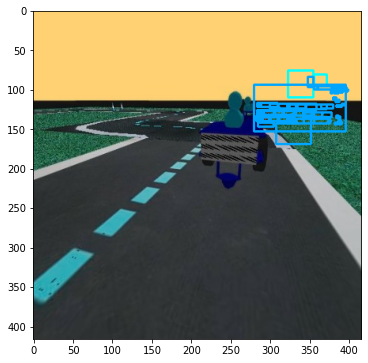

In [44]:
from matplotlib import pyplot as plt

yolo_data_img_path = '/content/dt_dataset/duckietown_dataset/train/images/real_1.jpg'
yolo_data_txt_path = '/content/dt_dataset/duckietown_dataset/train/labels/real_1.txt'
colors = {0: (0, 255, 255), 1: (0, 165, 255), 2: (0, 250, 0), 3: (0, 0, 255)}


# removing the new line characters
with open(yolo_data_txt_path) as f:
    objs = [line.rstrip().split(' ') for line in f]

img_ori = cv2.imread(yolo_data_img_path)
x_shape, y_shape, channel = img_ori.shape

for obj in objs:
    o, x, y, w, h = obj

    pt1 = np.array([int(x_shape * (float(x) + float(w)/2)), int(y_shape * (float(y) + float(h)/2))])
    pt2 = np.array([int(x_shape * (float(x) - float(w)/2)), int(y_shape * (float(y) - float(h)/2))])
    img_ori = cv2.rectangle(img_ori, pt1, pt2, colors[int(o)], 2)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_ori)

## Clone Yolov5

In [ ]:
!git clone https://github.com/guthi1/yolov5.git -b dt-obj-det
!cd yolov5 && pip3 install -r requirements.txt
!pip3 install torch==1.11 torchvision==0.12.0
if not os.path.exists("SENTINEL"):
  run("mv duckietown_dataset yolov5")
!touch SENTINEL

# Training 

## Logger

Create a loggin system with wandb

In [ ]:
%pip install -q wandb 
import wandb
wandb.login()

     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 168 kB 71.2 MB/s 
     |████████████████████████████████| 182 kB 70.5 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 168 kB 74.3 MB/s 
     |████████████████████████████████| 166 kB 82.6 MB/s 
     |████████████████████████████████| 166 kB 83.9 MB/s 
     |████████████████████████████████| 162 kB 84.8 MB/s 
     |████████████████████████████████| 162 kB 75.5 MB/s 
     |████████████████████████████████| 158 kB 83.3 MB/s 
     |████████████████████████████████| 157 kB 85.4 MB/s 
     |████████████████████████████████| 157 kB 78.8 MB/s 
     |████████████████████████████████| 157 kB 81.1 MB/s 
     |████████████████████████████████| 157 kB 82.3 MB/s 
     |████████████████████████████████| 157 kB 84.4 MB/s 
     |████████████████████████████████| 157 kB 79.1 MB/s 
     |████████████████████████████████| 157 kB 80.6 MB/s 
     |███████████

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Training

In [ ]:
!mv yolov5/best.pt yolov5/best_old.pt
!cd yolov5 && pip3 install -r requirements.txt && python3 train.py --img 416 --batch 16 --epochs 30 --data duckietown.yaml --weights yolov5s.pt

import numpy as np

all_exps = os.listdir("yolov5/runs/train")
all_exps_filtered = map(lambda x: int(x.replace("exp", "1")), filter(lambda x: x.startswith("exp"), all_exps))
all_exps_filtered = np.array(list(all_exps))
latest_exp_index = np.argmax(all_exps)
latest_exp = all_exps[latest_exp_index]
print(f"Latest exp is {latest_exp}")

prun(f"cp yolov5/runs/train/{latest_exp}/weights/best.pt yolov5/best.pt")

mv: cannot stat 'yolov5/best.pt': No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
github: up to date with https://github.com/guthi1/yolov5 ✅
YOLOv5 🚀 v5.0-69-g68abb22 torch 1.11.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='./data/duckietown.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir 

# Results the model

In [ ]:
import sys
import torch

def select_device(device='', batch_size=None):
    import torch
    # device = 'cpu' or '0' or '0,1,2,3'
    cpu = device.lower() == 'cpu'
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # force torch.cuda.is_available() = False
    elif device:  # non-cpu device requested
        os.environ['CUDA_VISIBLE_DEVICES'] = device  # set environment variable
        assert torch.cuda.is_available(), f'CUDA unavailable, invalid device {device} requested'  # check availability

    cuda = not cpu and torch.cuda.is_available()

    return torch.device('cuda:0' if cuda else 'cpu')

In [ ]:
# model = torch.load("./yolov5/best.pt", map_location=select_device("cpu"))['model'].float()  # load to FP32
# img = 'https://ultralytics.com/images/zidane.jpg'  # or file, Path, PIL, OpenCV, numpy, list
# # Inference
# results = model(img)

# # Results
# results.print()  # or .show(), .save(), .crop(), .pandas(), etc.


## Upload model to Duckietown's cloud

In [ ]:
!pip3 install git+https://github.com/duckietown/lib-dt-mooc-2021

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/duckietown/lib-dt-mooc-2021 to /tmp/pip-req-build-xelf8glx
  Running command git clone -q https://github.com/duckietown/lib-dt-mooc-2021 /tmp/pip-req-build-xelf8glx
     |████████████████████████████████| 142 kB 5.3 MB/s 
  Created wheel for dt-mooc-2021: filename=dt_mooc_2021-0.0.0-py3-none-any.whl size=6447 sha256=d7648157abf8be3a6ecfa040c13d3ed0a8f43a8ea76f4f91d463a8dc6da3e843
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbr49wgj/wheels/d5/df/21/aa957c23320a8241d9197289a987390c37adce3463c5ef9df8
  Created wheel for dt-data-api-daffy: filename=dt_data_api_daffy-1.1.3-py3-none-any.whl size=13714 sha256=80bb047bdbf2ae51320b31b52ada637f018480c2f339d7530154d76c90573a0d
  Stored in directory: /root/.cache/pip/wheels/38/ce/fb/5a988e5766d210a7586879219893e14a85ebca9f179ee91041
  Created wheel for dt-authentication-daffy: filename=dt_authentication_daffy-0.1.16

In [ ]:
from dt_mooc.cloud import Storage
import sys
import torch

def select_device(device='', batch_size=None):
    import torch
    # device = 'cpu' or '0' or '0,1,2,3'
    cpu = device.lower() == 'cpu'
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # force torch.cuda.is_available() = False
    elif device:  # non-cpu device requested
        os.environ['CUDA_VISIBLE_DEVICES'] = device  # set environment variable
        assert torch.cuda.is_available(), f'CUDA unavailable, invalid device {device} requested'  # check availability

    cuda = not cpu and torch.cuda.is_available()

    return torch.device('cuda:0' if cuda else 'cpu')

sys.path.insert(0, './yolov5')
model = torch.load("./yolov5/best.pt", map_location=select_device("cpu"))['model'].float()  # load to FP32
model.to(select_device("cpu")).eval()

storage = Storage("dt1-3nT8KSoxVh4Migd7N6Nsjy5q8BHtzjcsyz57x9FyJbx5UhJ-43dzqWFnWd8KBa1yev1g3UKnzVxZkkTbfex5eXnmoSTSmB3YdtDmc5tQuXNDk3cQ74")

storage.upload_yolov5("yolov5_duckie_duckiebot", model, "./yolov5/best.pt")

Uploading file `best.pt`...

File `best.pt` successfully uploaded! It will now be found at `courses/mooc/2021/data/nn_models/yolov5_duckie_duckiebot.pt`.
Uploading file `best.pt.wts`...

File `best.pt.wts` successfully uploaded! It will now be found at `courses/mooc/2021/data/nn_models/yolov5_duckie_duckiebot.wts`.
Uploading file `best.pt.wts.sha256`...

File `best.pt.wts.sha256` successfully uploaded! It will now be found at `courses/mooc/2021/data/nn_models/yolov5_duckie_duckiebot.sha256`.


# Done!